# Linear Regression with Statsmodels for Movie Revenue

- 07/12/22
-Purvi

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Today we will be working with JUST the data data from the TMDB API for years 2000-2021. 
    - We will prepare the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We will fit a statsmodels linear regression.
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.



- Next class we will continue this activity.
    - We will better check all 4 assumptions.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations.

### Concepts Demonstrated

- [ ] Using `glob` for loading in all final files. 
- [ ] Statsmodels OLS
- [ ] QQ-Plot
- [ ] Residual Plot

# Loading the Data

In [71]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

In [72]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [73]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
file_list

['.DS_Store',
 '2010-2021',
 'combined_all_data.csv.gz',
 'combined_tmdb_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2002.json',
 'tmdb_api_results_2003.json',
 'tmdb_api_results_2004.json',
 'tmdb_api_results_2005.json',
 'tmdb_api_results_2006.json',
 'tmdb_api_results_2007.json',
 'tmdb_api_results_2008.json',
 'tmdb_api_results_2009.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 '

In [74]:
## Try loading in the first .csv.gz file from the list


> Why isn't it working?

- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [75]:
import glob
## Make a filepath query
q = FOLDER+"final*.csv.gz"
q

'Data/final*.csv.gz'

In [76]:
# Use glob.glob to get COMPLETE filepaths
file_list = glob.glob(q)
file_list

['Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz']

> But where are the rest of the years?

In [77]:
## read one of the files in file_list
pd.read_csv(file_list[0], lineterminator='\n')


,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,tt7503878,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,481010.0,fr,Vintage Erotica Anno 1920,19 remastered French short films from the 20'...,0.840,/iVmJ5s3bgHaqCaDTBQ6mh4cxqgx.jpg,[],"[{'iso_3166_1': 'FR', 'name': 'France'}]",2006-08-01,0.0,90.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Vintage Erotica Anno 1920,0.0,9.0,1.0,NaN
1791,tt7775532,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.youtube.com/watch?v=_neakMwmoCY,939621.0,en,Neck of da Woodz,Five brothas run outta gas in the sticks and r...,0.600,/AgSO3MvqVbqKqBtQjWPmgAEteNW.jpg,"[{'id': 170026, 'logo_path': None, 'name': '2 ...",[],NaN,0.0,72.0,[],Released,Survival is all that matters when Boyz from th...,Neck of da Woodz,0.0,10.0,1.0,NaN
1792,tt8165062,0.0,NaN,"{'id': 800116, 'name': 'Survive Girls', 'poste...",0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800112.0,ja,Sabaibu,Experience two erotic tales of survival that w...,1.343,/8V80ADHG6UqpNwUWL8v7pAWnW3S.jpg,[],"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2010-10-26,0.0,86.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Survive Girls,0.0,0.0,0.0,NaN
1793,tt8784950,0.0,NaN,NaN,0.0,[],NaN,939503.0,zh,浅蓝深蓝,NaN,0.600,/baG7vzBr1yAwVHd7nYH1SmAFVBs.jpg,[],[],2006-01-31,0.0,0.0,[],Released,NaN,浅蓝深蓝,0.0,0.0,0.0,NaN


- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [78]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"**/final*.csv.gz"
file_list = glob.glob(q, recursive=True)
file_list

['Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz']

In [79]:
# example using for loop to load all files into 1 dataframe
df_list = []
for file in file_list:
    temp_df = pd.read_csv(file, lineterminator='\n')
    df_list.append(temp_df)
len(df_list)

22

In [80]:
# concat all the files
pd.concat(df_list)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,North point,0.0,0.0,0.0,NaN


In [81]:
# ## use a list comprehension to load in all files into 1 dataframe
df = pd.concat([ pd.read_csv(file, lineterminator='\n') for file in file_list])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,North point,0.0,0.0,0.0,NaN


- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [82]:
# remove ids that are 0  and then reset index
df = df.loc[ df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
5,tt0244521,0.0,/4W53mm2nvOtiOuPNW2oiBm9pmUZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9925.0,en,Funny Money,"Henry Perkins, a mild-mannered accountant, acc...",5.591,/oG3jWUZiDqqrdk3oKwPEkuwoN89.jpg,"[{'id': 110622, 'logo_path': None, 'name': 'FW...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2006-01-01,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Henry Perkins accidentally trades briefcases w...,Funny Money,0.0,5.4,39.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,Nort

In [83]:
df.reset_index(inplace=True)


In [84]:
## saving the combined csv to disk
df.to_csv('Data/combined_all_data.csv.gz', compression="gzip", index = False)

# Preprocessing

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  60130 non-null  int64  
 1   imdb_id                60130 non-null  object 
 2   adult                  60130 non-null  float64
 3   backdrop_path          36994 non-null  object 
 4   belongs_to_collection  3738 non-null   object 
 5   budget                 60130 non-null  float64
 6   genres                 60130 non-null  object 
 7   homepage               14776 non-null  object 
 8   id                     60130 non-null  float64
 9   original_language      60130 non-null  object 
 10  original_title         60130 non-null  object 
 11  overview               58761 non-null  object 
 12  popularity             60130 non-null  float64
 13  poster_path            54382 non-null  object 
 14  production_companies   60130 non-null  object 
 15  pr

In [86]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','status','tagline','id','homepage',
                 'production_countries','video','production_companies','spoken_languages',
            'original_language']

## drop columns
df = df.drop(columns=drop_cols)
df

,index,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,1,tt0144280,0.0,NaN,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN
1,2,tt0197633,0.0,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR
2,3,tt0204250,0.0,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN
3,4,tt0206634,0.0,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R
4,5,tt0244521,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,2893,tt9282946,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN
60126,2894,tt9385434,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN
60127,2895,tt9452878,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN
60128,2896,tt9519786,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN


## Feature Engineering


- belongs to collection: convert to boolean
- Genres: get just name and manually OHE
- Cleaning Categories in Certification
- Converting release date to year, month, and day.

### belongs to collection
- convert to boolean

In [87]:
df['belongs_to_collection'].value_counts()

{'id': 39199, 'name': 'Detective Conan Collection', 'poster_path': '/1wBfr532NOQK68wlo5ApjCmiQIB.jpg', 'backdrop_path': '/9bogrpii4e61SR6a9qLHow7I46U.jpg'}               18
{'id': 148065, 'name': 'Doraemon Collection', 'poster_path': '/4TLSP1KD1uAlp2q1rTrc6SFlktX.jpg', 'backdrop_path': '/rc6OFcSasL5YxBRPUQVwxmVF6h5.jpg'}                     16
{'id': 403643, 'name': 'Troublesome Night Collection', 'poster_path': '/bPTx3TP4UJTHQfcLx4qIub9LXmi.jpg', 'backdrop_path': '/n3a7zF5GuxM2X8oPF6pKXqYS6ER.jpg'}            15
{'id': 23456, 'name': 'One Piece Collection', 'poster_path': '/nvAPotUDNcKStSOv2ojGZBNOX8A.jpg', 'backdrop_path': '/3RqSKjokWlXyTBUt3tcR9CrOG57.jpg'}                     13
{'id': 23616, 'name': 'Naruto Collection', 'poster_path': '/q9rrfRgPUFkFqDF74jlvNYp3RpN.jpg', 'backdrop_path': '/prLI2SNNkd9wcQkFh9iWXzQtR5D.jpg'}                        11
                                                                                                                                       

In [88]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'] = df['belongs_to_collection'].isna()
df['belongs_to_collection'].value_counts(dropna=False)

True     56392
False     3738
Name: belongs_to_collection, dtype: int64

In [89]:
## Use .notna() to get True if it belongs to a collection


### genre
- get just name and manually OHE

In [90]:
df.loc[5,'genres']

"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}, {'id': 53, 'name': 'Thriller'}]"

In [91]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [92]:
## Use our function and exploding the new column
df['genre_list'] = df['genres'].apply(get_genre_name)
df.head()

,index,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list
0,1,tt0144280,0.0,True,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,[]
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,"[Animation, Comedy, Music, Science Fiction]"
2,3,tt0204250,0.0,True,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,"[Mystery, Comedy]"
3,4,tt0206634,0.0,True,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,"[Drama, Action, Thriller, Science Fiction]"
4,5,tt0244521,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,"[Comedy, Crime]"


In [93]:
df_explode = df.explode('genre_list')
df_explode

,index,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list
0,1,tt0144280,0.0,True,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,NaN
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Animation
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Comedy
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Music
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Science Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60127,2895,tt9452878,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,Drama
60127,2895,tt9452878,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,Music
60128,2896,tt9519786,0.0,True,0.0,"[{'id': 18, 'name': 'Drama'}]",1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,Drama
60129,2897,tt9547900,0.0,True,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",1.343,2011-05-13,0.0,0.0,百年情书,0.0,0.0,NaN,Drama


In [94]:
## save unique genres
unique_genres = df_explode['genre_list'].dropna().unique()
unique_genres

array(['Animation', 'Comedy', 'Music', 'Science Fiction', 'Mystery',
       'Drama', 'Action', 'Thriller', 'Crime', 'Romance', 'Horror',
       'Adventure', 'Family', 'Fantasy', 'History', 'Documentary', 'War',
       'Western', 'TV Movie'], dtype=object)

In [95]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    
df

,index,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
0,1,tt0144280,0.0,True,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,tt0197633,0.0,True,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,"[Animation, Comedy, Music, Science Fiction]",True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,tt0204250,0.0,True,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,"[Mystery, Comedy]",False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,tt0206634,0.0,True,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,"[Drama, Action, Thriller, Science Fiction]",False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,5,tt0244521,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,"[Comedy, Crime]",False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,2893,tt9282946,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}]",0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN,[Comedy],False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,2894,tt9385434,0.0,True,0.0,"[{'id': 18, 'name': 'Drama'}]",1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN,[Drama],False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,2895,tt9452878,0.0,True,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,"[Comedy, Drama, Music]",False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,2896,tt9519786,0.0,True,0.0,"[{'id': 18, 'name': 'Drama'}]",1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,[Drama],False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [96]:
## Drop original genre cols
df = df.drop(columns=['genres','genre_list','index'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
0,tt0144280,0.0,True,100000.0,1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0197633,0.0,True,0.0,3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0204250,0.0,True,0.0,0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0206634,0.0,True,76000000.0,19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0244521,0.0,True,0.0,5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,True,0.0,0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt9385434,0.0,True,0.0,1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt9452878,0.0,True,0.0,1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9519786,0.0,True,0.0,1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


### certification
- Cleaning Categories in Certification

In [97]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

NaN                                45506
R                                   6097
NR                                  3261
PG-13                               3224
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
ScreamFest Horror Film Festival        1
UR                                     1
Not Rated                              1
-                                      1
PG-13                                  1
10                                     1
R                                      1
Name: certification, dtype: int64

In [98]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()
df['certification'].value_counts(dropna=False)

NaN                                45506
R                                   6098
NR                                  3261
PG-13                               3225
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
ScreamFest Horror Film Festival        1
UR                                     1
Not Rated                              1
-                                      1
10                                     1
Name: certification, dtype: int64

In [99]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)#

df['certification'].value_counts()

R        6098
NR       3270
PG-13    3225
PG       1432
G         442
NC-17     156
Name: certification, dtype: int64

### Converting release date to sep features
- Converting release date to year, month, and day.

In [100]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
df.head()

,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day
0,tt0144280,0.0,True,100000.0,1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1997.0,1.0,1.0
1,tt0197633,0.0,True,0.0,3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,31.0
2,tt0204250,0.0,True,0.0,0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,18.0
3,tt0206634,0.0,True,76000000.0,19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,22.0
4,tt0244521,0.0,True,0.0,5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,1.0


In [101]:
## drop original feature
df = df.drop(columns=['release_date'])

## Train Test Split

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   revenue                60130 non-null  float64
 6   runtime                59298 non-null  float64
 7   title                  60130 non-null  object 
 8   vote_average           60130 non-null  float64
 9   vote_count             60130 non-null  float64
 10  certification          14623 non-null  object 
 11  Genre_Animation        60130 non-null  bool   
 12  Genre_Comedy           60130 non-null  bool   
 13  Genre_Music            60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [103]:
## Make x and y variables
drop_for_model = ['title','imdb_id']

y = df['revenue'].copy()
X = df.drop(columns=['revenue',*drop_for_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day
9538,0.0,True,0.0,0.600,70.0,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2007.0,10.0,24.0
16553,0.0,True,0.0,9.087,100.0,6.1,141.0,NaN,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2018.0,12.0,7.0
34106,0.0,True,10.0,1.842,89.0,4.5,4.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2012.0,3.0,18.0
3804,0.0,True,0.0,1.092,97.0,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2008.0,8.0,7.0
37747,0.0,True,0.0,1.209,98.0,2.8,8.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019.0,7.0,12.0


In [104]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    626
vote_average                 0
vote_count                   0
certification            34093
Genre_Animation              0
Genre_Comedy                 0
Genre_Music                  0
Genre_Science Fiction        0
Genre_Mystery                0
Genre_Drama                  0
Genre_Action                 0
Genre_Thriller               0
Genre_Crime                  0
Genre_Romance                0
Genre_Horror                 0
Genre_Adventure              0
Genre_Family                 0
Genre_Fantasy                0
Genre_History                0
Genre_Documentary            0
Genre_War                    0
Genre_Western                0
Genre_TV Movie               0
year                       760
month                      760
day                        760
dtype: int64

In [105]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [106]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Animation',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Science Fiction',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Thriller',
 'Genre_Crime',
 'Genre_Romance',
 'Genre_Horror',
 'Genre_Adventure',
 'Genre_Family',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Documentary',
 'Genre_War',
 'Genre_Western',
 'Genre_TV Movie']

In [107]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [108]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'belongs_to_collection',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'Genre_Animation',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Science Fiction',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Thriller',
 'Genre_Crime',
 'Genre_Romance',
 'Genre_Horror',
 'Genre_Adventure',
 'Genre_Family',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Documentary',
 'Genre_War',
 'Genre_Western',
 'Genre_TV Movie',
 'year',
 'month',
 'day']

In [109]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols),
                                       ('passthrough',already_ohe_cols))# remainder='passthrough')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'belongs_to_collection', 'budget',
                                  'popularity', 'r...
                                ('passthrough', 'passthrough',
                                 ['belongs_to_collection', 'Genre_Animation',
                                  'Genre_Comedy', 'Genre_Music',
                                  'Genre_Science Fiction', 'Genre_Mystery',
                                  'Genre_Drama', 'Genre_Action',
                                  'Genre_Thriller', 'Genre_Crime',
                                  'Genre_Romance', 'Genre_Horror',
                                  'Genre_Adventure', 'Genre_Family',
                                  'Genre_Fantasy', 'Genre_History',
                                  'Genre_Documentary', 'Genre_War',
                                  'Genre_Western', 'Genre_TV Movie'])])

In [110]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [111]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-1'][-1].get_feature_names_out(cat_cols)

## Create the empty list
final_features = [*cat_features,*num_cols,*already_ohe_cols]
len(final_features)

56

In [112]:
## checking shape matches len final features
preprocessor.transform(X_train).shape

(45097, 56)

In [113]:
## make X_train_tf 
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
9538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,10.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.087,100.0,6.1,141.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.842,89.0,4.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012.0,3.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.092,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,8.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.209,98.0,2.8,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,7.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
## make X_test_tf 

X_test_tf = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
19252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.911,90.0,4.5,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.911,148.0,5.1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.728,78.0,5.4,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010.0,9.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.719,97.0,6.1,21.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.549,160.0,6.8,124.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [115]:

##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [116]:
## Make final X_train_df and X_test_df with constants added
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add') 
X_test_df

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,const
19252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.911,90.0,4.5,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.911,148.0,5.1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.728,78.0,5.4,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010.0,9.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.719,97.0,6.1,21.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.549,160.0,6.8,124.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.511,110.0,5.9,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,2.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36554,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.892,100.0,4.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010.0,3.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.716,87.0,5.9,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,10.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.073,0.0,6.3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021.0,8.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [117]:
display(X_train_df.head(2),X_test_df.head(2))

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,const
9538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,10.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.087,100.0,6.1,141.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,const
19252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.911,90.0,4.5,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.911,148.0,5.1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 🕹 Part 2: Checking Model Assumptions

## Modeling

## Statsmodels OLS

In [118]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     3939.
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:45:57   Log-Likelihood:            -8.4104e+05
No. Observations:               45097   AIC:                         1.682e+06
Df Residuals:                   45061   BIC:                         1.682e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G       -2.659e+06   6.64e+06     -0.401      0.689   -1.57e+07    1.04e+07
certification_MISSING -1.878e+06   6.52e+06     -0.288      0.773   -1.46e+07    1.09e+07
certification_NC-17   -8.018e+06   6.95e+06     -1.154      0.248   -2.16e+07     5.6e+06
certification_NR      -2.917e+06   6.54e+06     -0.446      0.656   -1.57e+07    9.91e+06
certification_PG      -2.405e+06   6.53e+06     -0.368      0.713   -1.52e+07    1.04e+07
certification_PG-13   -1.277e+07   6.49e+06     -1.968      0.049   -2.55e+07   -4.94e+04
certification_R       -1.582e+07   6.46e+06     -2.448      0.014   -2.85e+07   -3.15e+06
adult                  2.307e+06   3.66e+06      0.630      0.529   -4.87e+06    9.48e+06
belongs_to_collection  -5.55e+06   3.22e+05    -17.249      0.000   -6.18e+06   -4.92e+06
budget                    1.6290      0.014    117.762      0.000       1.602       1.656
popularity             1.413e+05   4374.434     32.294      0.000    1.33e+05     1.5e+05
runtime               -7996.9801   5118.052     -1.563      0.118    -1.8e+04    2034.486
vote_average          -4.922e+05   5.93e+04     -8.301      0.000   -6.08e+05   -3.76e+05
vote_count             2.784e+04    198.084    140.535      0.000    2.74e+04    2.82e+04
Genre_Animation        6.746e+05   4.47e+05      1.509      0.131   -2.02e+05    1.55e+06
Genre_Comedy          -1.381e+05   1.76e+05     -0.783      0.434   -4.84e+05    2.08e+05
Genre_Music            3.939e+05   5.18e+05      0.761      0.447   -6.21e+05    1.41e+06
Genre_Science Fiction -2.128e+06   3.29e+05     -6.468      0.000   -2.77e+06   -1.48e+06
Genre_Mystery         -8.647e+05   3.38e+05     -2.557      0.011   -1.53e+06   -2.02e+05
Genre_Drama           -8.231e+04   1.64e+05     -0.501      0.616   -4.04e+05     2.4e+05
Genre_Action          -7.527e+05   2.46e+05     -3.059      0.002   -1.23e+06    -2.7e+05
Genre_Thriller        -8.522e+05    2.1e+05     -4.062      0.000   -1.26e+06   -4.41e+05
Genre_Crime           -1.326e+06   2.87e+05     -4.621      0.000   -1.89e+06   -7.64e+05
Genre_Romance         -1.013e+05   2.23e+05     -0.455      0.649   -5.38e+05    3.35e+05
Genre_Horror           1.238e+05   2.23e+05      0.555      0.579   -3.14e+05    5.61e+05
Genre_Adventure         1.16e+06   3.64e+05      3.183      0.001    4.46e+05    1.87e+06
Genre_Family          -3.488e+05   3.61e+05     -0.966      0.334   -1.06e+06    3.59e+05
Genre_Fantasy         -3.769e+05   3.59e+05     -1.050      0.294   -1.08e+06    3.26e+05
Genre_History          -2.42e+06   4.91e+05     -4.926      0.000   -3.38e+06   -1.46e+06
Genre_Documentary      3.129e+05   8.66e+05      0.361      0.718   -1.38e+06    2.01e+06
Genre_War             -8.515e+05   5.93e+05     -1.436      0.151   -2.01e+06     3.1e+05
Genre_Western         -

In [119]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)

print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)

print(f'Test R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.754
Test R^2: 0.759


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ(Quantile-Quantile)-Plot for Checking for Normality

<AxesSubplot:ylabel='Count'>

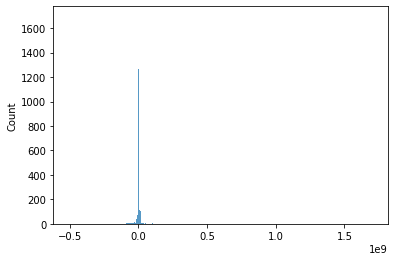

In [120]:
## Create a Q-QPlot
resids = y_train - y_hat_train
sns.histplot(resids)

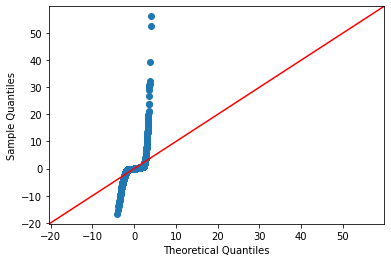

In [121]:
# first calculate residuals 
sm.graphics.qqplot(resids, fit=True, line='45');
## then use sm's qqplot with line='45' fit=True

### Residual Plot for Checking Homoscedasticity

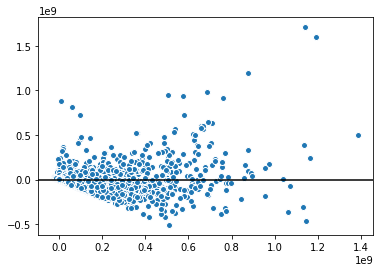

In [122]:
## Plot scatterplot with y_hat_test vs resids
plt.scatter(y_hat_train, resids, ec='white')
plt.axhline(0,color='k');

### Putting it all together

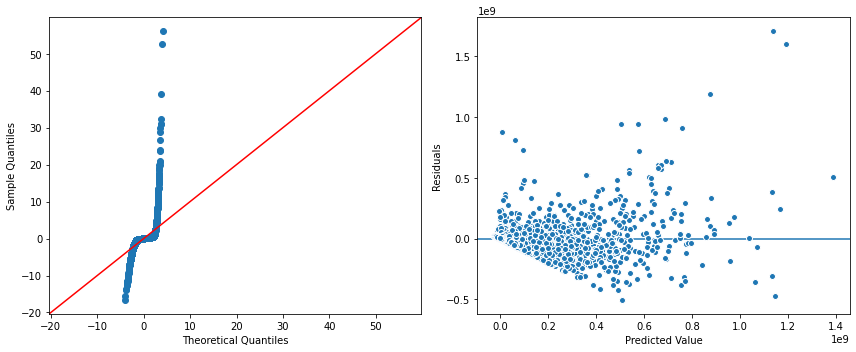

In [123]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)



> iterating on our model & interpreting coefficients

# Improving Our Model:

"Garbage In = Garbage Out"

Before we dive into iterating on our model, I realized there were some big issues that I did not account for in the original data.
some movies may not have been released.
We should probably remove movies with 0 budget and revenue.

In [124]:
## reload the data
df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13


## Repeating Feature Engineering

In [125]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)

## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certification'].value_counts(dropna=False)
# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df


,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Released,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,Released,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,Released,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Released,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Released,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Released,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Released,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,Released,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Released,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


New Filtering
- Make sure to only keep:
    - Status=Released.
    - Budget >0
    - Revenue >0

In [126]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [127]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [128]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
6,tt0411951,0.0,True,30000000.0,70.694,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...",9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,tt0427152,0.0,False,69000000.0,21.747,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...",8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,tt0429493,0.0,False,110000000.0,56.494,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...",1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
11,tt0435761,0.0,True,200000000.0,93.983,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...",1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59859,tt1532382,0.0,True,3500000.0,4.838,[],3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,tt1542960,0.0,False,300000.0,1.937,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...",2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59923,tt1560950,0.0,True,600.0,1.795,[],3.000000e+00,81.0,D@bbe 2,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0
59929,tt1565058,0.0,True,125000.0,5.989,"[{'id': 4580, 'logo_path': None, 'name': 'Cine...",3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


### Production Company

In [129]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax 

44234

In [130]:
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [131]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)
# df['production_companies'].str.extractall(exp,expand=False)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [132]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies
#     return ','.join(companies)

In [133]:
# df[df['prod_company'] =='']
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [134]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()#.nunique()

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_44121/3339258235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_company'] = df['production_companies'].apply(get_prod_company_names)


In [135]:

prod_companies.value_counts().head(49)

Universal Pictures           285
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             195
Paramount                    178
MISSING                      167
Canal+                       152
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    121
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Sony Pictures                 62
Regency Enterprises           62
Working Title Films           56
Blumhouse Productions         55
Dimension Films               55
Legendary Pictures            51
The Weinstein Company         50
Millennium

Common Prod Company Encoding:
- Keep top 50 most common companies an one hot encode

In [136]:
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [137]:
len(common_companies)


50

In [138]:

## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_44121/2543914919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)


In [139]:
## Dropping columns
drop_for_model = ['title','imdb_id','prod_company','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

### Checking for Linearity


In [142]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
#plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
#len(plot_cols)

In [143]:
# ## save plot_cols list to show (dropping genre from plot_df from pair_plot)
#sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6])

In [144]:
## plot remaining features
#Shouldn't have years before 2000, so drop.
#Check outliers in popularity, runtime


In [145]:
# remove movies prior to 2000
df = df.loc[ df['year']>=2000]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

Now need to recreate X and y varaibles

## Functionize ALL of the preprocessing

In [146]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, X_test_df, y_train, y_test

In [147]:
## Use our function to make new x,y vars
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
X_train_df

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
34060,0.0,20140.0,2.975,75.0,0.0,0.0,2020.0,12.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54089,0.0,20000000.0,9.213,84.0,5.1,193.0,2007.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19970,0.0,20000000.0,31.873,107.0,6.1,675.0,2016.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5834,0.0,50000000.0,101.253,107.0,6.4,10572.0,2012.0,6.0,29.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
49880,0.0,2500000.0,1.992,82.0,6.5,13.0,2004.0,8.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     146.7
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:50:40   Log-Likelihood:                -75172.
No. Observations:                3810   AIC:                         1.505e+05
Df Residuals:                    3726   BIC:                         1.510e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                     5.312e+06   9.08e+07      0.058      0.953   -1.73e+08    1.83e+08
certification_MISSING                  1.7419      0.059     29.345      0.000       1.625       1.858
certification_NC-17                 1.663e+05   1.48e+04     11.206      0.000    1.37e+05    1.95e+05
certification_NR                    2.298e+05   8.53e+04      2.695      0.007    6.26e+04    3.97e+05
certification_PG                   -3.504e+06   1.48e+06     -2.362      0.018   -6.41e+06   -5.95e+05
certification_PG-13                 3.044e+04    693.316     43.907      0.000    2.91e+04    3.18e+04
certification_R                     2.741e+05   2.84e+05      0.966      0.334   -2.82e+05     8.3e+05
adult                              -1.372e+05   4.38e+05     -0.313      0.754   -9.95e+05    7.21e+05
budget                              1.869e+04   1.73e+05      0.108      0.914   -3.21e+05    3.59e+05
popularity                         -8.069e+07   7.13e+07     -1.131      0.258   -2.21e+08    5.91e+07
runtime                            -6.161e+07   7.19e+07     -0.856      0.392   -2.03e+08    7.94e+07
vote_average                       -6.878e+07    7.5e+07     -0.917      0.359   -2.16e+08    7.83e+07
vote_count                         -6.923e+07   7.21e+07     -0.960      0.337   -2.11e+08    7.21e+07
year                               -6.297e+07   7.14e+07     -0.882      0.378   -2.03e+08     7.7e+07
month                              -7.203e+07   7.14e+07     -1.009      0.313   -2.12e+08     6.8e+07
day                                -8.659e+07   7.14e+07     -1.213      0.225   -2.27e+08    5.34e+07
belongs_to_collection               4.553e+07   4.03e+06     11.290      0.000    3.76e+07    5.34e+07
Genre_Family                       -1.184e+07   7.63e+06     -1.551      0.121   -2.68e+07    3.13e+06
Genre_Animation                     2.273e+07   8.32e+06      2.730      0.006    6.41e+06     3.9e+07
Genre_Science Fiction              -2.973e+07   5.58e+06     -5.327      0.000   -4.07e+07   -1.88e+07
Genre_Thriller                     -4.875e+06   4.11e+06     -1.187      0.235   -1.29e+07    3.18e+06
Genre_Mystery                      -1.012e+07   5.63e+06     -1.797      0.072   -2.12e+07    9.21e+05
Genre_Drama                         1.075e+05   3.88e+06      0.028      0.978    -7.5e+06    7.72e+06
Genre_Romance                       3.641e+06   4.32e+06      0.842      0.400   -4.83e+06    1.21e+07
Genre_Comedy                        3.598e+06   3.88e+06      0.927      0.354   -4.01e+06    1.12e+07
Genre_War                          -2.388e+05   8.26e+06     -0.029      0.977   -1.64e+07     1.6e+07
Genre_Crime                        -2.024e+06   4.67e+06     -0.434      0.665   -1.12e+07    7.

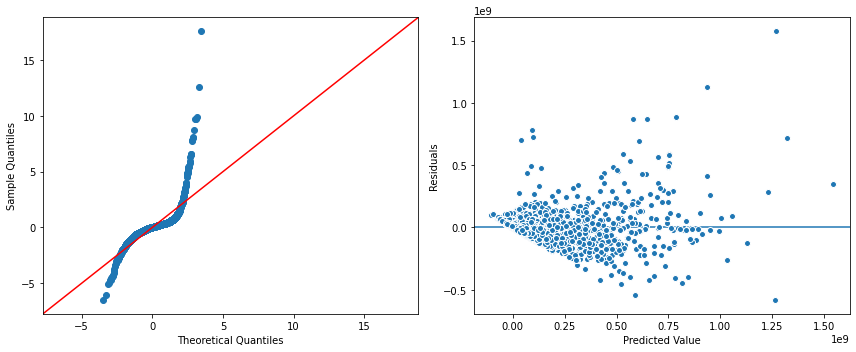

In [148]:
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)
result.summary()

## Removing Outliers


#### Using Z-Score Rule

In [149]:
from scipy import stats
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [150]:
outlier_cols = df.select_dtypes('number').columns
outlier_cols

Index(['adult', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'year', 'month', 'day'],
      dtype='object')

In [151]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outliers = {}

for col in outlier_cols:
    idx_outliers = find_outliers( df[col])
    outliers[col] = idx_outliers
outliers.keys()

- 1 outliers found in adult using Z-Scores.
- 141 outliers found in budget using Z-Scores.
- 34 outliers found in popularity using Z-Scores.
- 128 outliers found in revenue using Z-Scores.
- 0 outliers found in runtime using Z-Scores.
- 96 outliers found in vote_average using Z-Scores.
- 132 outliers found in vote_count using Z-Scores.
- 0 outliers found in year using Z-Scores.
- 0 outliers found in month using Z-Scores.
- 0 outliers found in day using Z-Scores.


dict_keys(['adult', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'month', 'day'])

In [152]:
outliers['revenue']


4        False
6        False
9        False
10       False
11        True
         ...  
59859    False
59887    False
59923    False
59929    False
59937    False
Name: revenue, Length: 5081, dtype: bool

In [153]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4708 entries, 6 to 59937
Data columns (total 81 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   adult                               4708 non-null   float64
 1   belongs_to_collection               4708 non-null   bool   
 2   budget                              4708 non-null   float64
 3   popularity                          4708 non-null   float64
 4   revenue                             4708 non-null   float64
 5   runtime                             4707 non-null   float64
 6   vote_average                        4708 non-null   float64
 7   vote_count                          4708 non-null   float64
 8   certification                       3631 non-null   object 
 9   Genre_Family                        4708 non-null   bool   
 10  Genre_Animation                     4708 non-null   bool   
 11  Genre_Science Fiction               4708 n

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_44121/1104993295.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


### Model 2: Outliers Removed (Z_scores)

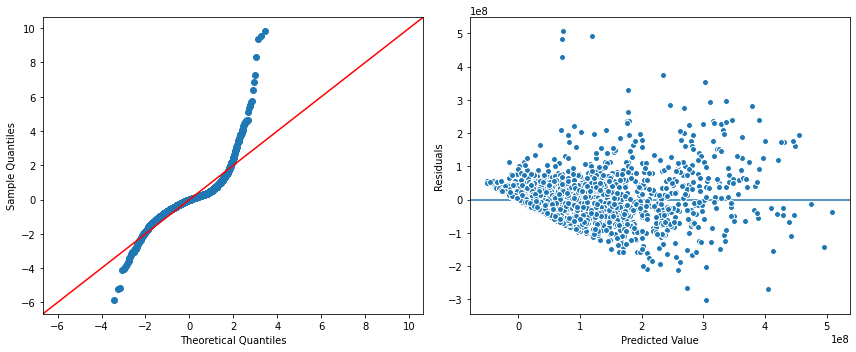

In [154]:
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df_clean)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

### Removing Outliers - Using IQR Rule

<AxesSubplot:xlabel='revenue'>

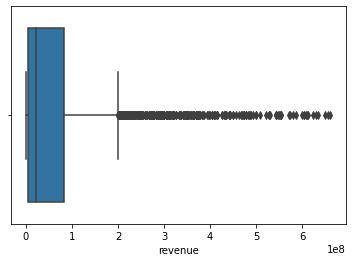

In [155]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)


In [156]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers


use new func to find outliers in target

In [157]:
## Loop to remove outliers from same clumns using new function
outlier_cols = num_cols#['runtime','popularity','revenue']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}

## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr
    print()
    

- 1 outliers found in adult using Z-Scores.
- 1 outliers found in adult using IQR.

- 0 outliers found in belongs_to_collection using Z-Scores.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [158]:
# remove_outliers
df_clean_iqr = df.copy()
for col, idx_outliers in outliers_iqr.items():
    df_clean_iqr = df_clean_iqr[~idx_outliers]
df_clean_iqr

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

### Model 3 - IQR Outliers Removed

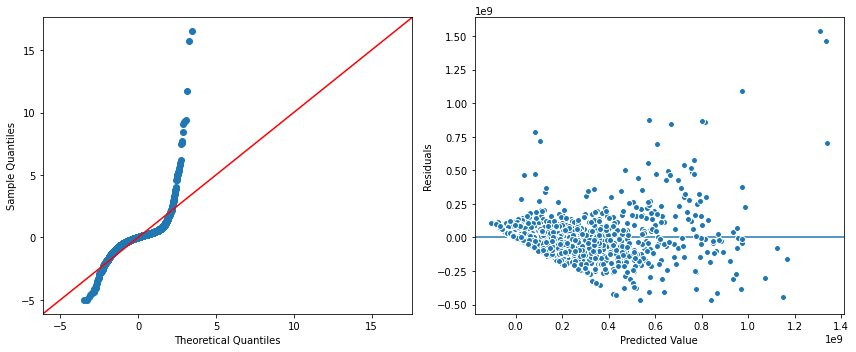

In [159]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df_clean_iqr)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

In [160]:

## get pvalues from model result
pvals = result.pvalues
pvals

certification_G                        1.519854e-01
certification_MISSING                 3.255909e-191
certification_NC-17                    2.459136e-01
certification_NR                       1.282543e-02
certification_PG                       4.126713e-02
                                          ...      
ProdComp_Village Roadshow Pictures     7.244226e-02
ProdComp_Walt Disney Pictures          6.728400e-01
ProdComp_Warner Bros. Pictures         1.860848e-06
ProdComp_Working Title Films           7.730763e-02
const                                  1.443776e-01
Length: 87, dtype: float64

In [161]:
## Check for p-values that are >.05
pvals[pvals >  .05]

certification_G                       0.151985
certification_NC-17                   0.245914
certification_R                       0.152215
adult                                 0.075274
budget                                0.223014
                                        ...   
ProdComp_Universal Pictures           0.089349
ProdComp_Village Roadshow Pictures    0.072442
ProdComp_Walt Disney Pictures         0.672840
ProdComp_Working Title Films          0.077308
const                                 0.144378
Length: 68, dtype: float64

### Removing features - based on p-values

### Addressing Multicollinearity


### Variance Inflation Factor

### FInal Model

### Summary